In [ ]:
#===============================================================================
#===========================Data Processing Script==============================

# This script is used to process the data from dicom to nifti and visualize the
# data in the nifti format.

# Author: Subash Katel
# ==============================================================================

In [27]:
#!/usr/bin/env python3
"""
Batch DICOM-to-NIfTI + Mask Processing with Fixed Shape
-------------------------------------------------------

1) Recursively searches a DICOM root directory for "Axial_T1weight_Lumbar" folders.
2) Parses subject/visit ID from path (e.g. "SBTMRI_001_V2" -> "SBT001_V2").
3) Loads DICOM images & mask volumes, ensuring shape = (224, 228, 384) by cropping/padding.
4) Computes:
     - L_Mult_II = L_Mult_I * L_ES_I
     - R_Mult_II = R_Mult_I * R_ES_I
     - L_ES_II   = L_ES_I - L_Mult_II
     - R_ES_II   = R_ES_I - R_Mult_II
5) Saves results in NIfTI format under OUTPUT_ROOT/<subjectID>/.

Caution:
 - Cropping may remove some data if original volume is larger.
 - Padding adds zeros if volume is smaller.
 - A more correct approach typically involves resampling to consistent voxel sizes.
"""

import os
import logging
import numpy as np
import nibabel as nib
from nibabel import Nifti1Image
import pydicom
from glob import glob
from pydicom.pixel_data_handlers.util import apply_modality_lut

# -------------------------------------------------------------------------
# Configuration
# -------------------------------------------------------------------------
DICOM_ROOT   = "/Volumes/advent/research/MRI/SWCC/DATA_dicom"
ROI_ROOT     = "/Volumes/advent/research/MRI/SWCC/ROIs"
OUTPUT_ROOT  = "/Volumes/advent/processed_data"
TARGET_SHAPE = (224, 228, 384)  # Desired final shape (Depth, Height, Width)

# If you want to pop up a matplotlib window for each processed subject, set True.
# Otherwise, it's recommended to keep it False for batch processing.
DO_VISUALIZATION = False

# Logging Setup
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s"
)

# -------------------------------------------------------------------------
# Shape Fixing Utility
# -------------------------------------------------------------------------
def fix_shape_to_standard(vol, target_shape=(224, 228, 384)):
    """
    Force the 3D array 'vol' to have shape == target_shape by:
      - Cropping any dimension that exceeds target_shape[dim].
      - Zero-padding any dimension that is smaller.

    Returns a new array of shape == target_shape.
    """
    if vol.ndim != 3:
        raise ValueError(f"Expected a 3D volume, got shape {vol.shape}.")

    fixed_vol = vol
    for dim in range(3):
        current_size = fixed_vol.shape[dim]
        target_size  = target_shape[dim]

        if current_size == target_size:
            continue

        elif current_size > target_size:
            # Crop
            slice_list = [slice(None), slice(None), slice(None)]
            slice_list[dim] = slice(0, target_size)
            fixed_vol = fixed_vol[tuple(slice_list)]

        else:
            # Pad
            pad_amount = target_size - current_size
            pad_width = [(0, 0), (0, 0), (0, 0)]
            pad_width[dim] = (0, pad_amount)
            fixed_vol = np.pad(fixed_vol, pad_width=pad_width, mode='constant', constant_values=0)

    # Final check
    if fixed_vol.shape != target_shape:
        raise ValueError(f"Shape fix failed. Got {fixed_vol.shape} instead of {target_shape}.")
    return fixed_vol


# -------------------------------------------------------------------------
# DICOM Loading Functions
# -------------------------------------------------------------------------
def load_dicom_images(folder):
    """
    Loads all .dcm files from `folder` into a single 3D NumPy array of shape (D,H,W),
    then crops/pads to TARGET_SHAPE.
    """
    dicom_files = sorted(glob(os.path.join(folder, "*.dcm")))
    if not dicom_files:
        raise ValueError(f"No DICOM files found in {folder}.")

    slices = []
    for f in dicom_files:
        ds = pydicom.dcmread(f)
        arr = apply_modality_lut(ds.pixel_array, ds)
        slices.append(arr)

    vol = np.stack(slices, axis=0)  # (num_slices, height, width)
    vol_fixed = fix_shape_to_standard(vol, TARGET_SHAPE)
    return vol_fixed

def load_dicom_masks(folder):
    """
    Loads mask .dcm files from `folder` as a 3D binary array (D,H,W).
    Any >0 pixel is set to 1, else 0. Also crops/pads to TARGET_SHAPE.
    """
    dicom_files = sorted(glob(os.path.join(folder, "*.dcm")))
    if not dicom_files:
        raise ValueError(f"No DICOM mask files found in {folder}.")

    slices = []
    for f in dicom_files:
        ds = pydicom.dcmread(f)
        arr = apply_modality_lut(ds.pixel_array, ds)
        arr_bin = np.where(arr > 0, 1, 0)
        slices.append(arr_bin)

    vol = np.stack(slices, axis=0)
    vol_fixed = fix_shape_to_standard(vol, TARGET_SHAPE)
    return vol_fixed

# -------------------------------------------------------------------------
# NIfTI Saving / Visualization
# -------------------------------------------------------------------------
def save_nifti(data, out_path):
    nii = Nifti1Image(data.astype(np.int16), affine=np.eye(4))
    nib.save(nii, out_path)
    logging.info(f"Saved: {out_path}")

if DO_VISUALIZATION:
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    def visualize_overlay_colored_masks(image_data, masks_dict, slice_idx=0):
        """
        Show a single slice with up to 4 colored masks overlaid.
        """
        colors = {
            "L_Mult_II": ListedColormap(["none", "green"]),
            "R_Mult_II": ListedColormap(["none", "yellow"]),
            "L_ES_II"  : ListedColormap(["none", "red"]),
            "R_ES_II"  : ListedColormap(["none", "blue"]),
        }

        plt.figure(figsize=(10, 8))
        plt.imshow(image_data[slice_idx], cmap="gray", interpolation="none")
        for mask_name, mask_vol in masks_dict.items():
            cmap = colors.get(mask_name, None)
            if cmap is not None:
                plt.imshow(
                    mask_vol[slice_idx],
                    cmap=cmap,
                    alpha=0.4,
                    interpolation="none"
                )
        plt.title(f"Overlay - Slice {slice_idx}")
        plt.axis("off")
        plt.show()
else:
    def visualize_overlay_colored_masks(*args, **kwargs):
        # Stub if visualization is turned off
        pass

# -------------------------------------------------------------------------
# Subject ID Parsing
# -------------------------------------------------------------------------
def parse_subject_id(path):
    """
    Tries to parse "SBTMRI_..." -> "SBT..." or "SBT..._V2" etc.
    Example:
      /.../SBTMRI_001/Axial_T1weight_Lumbar -> SBT001
      /.../SBTMRI_002_V2/Axial_T1weight_Lumbar -> SBT002_V2
    """
    parts = path.split(os.sep)
    for p in parts:
        if p.startswith("SBTMRI_"):
            return p.replace("MRI_", "")
    return None

# -------------------------------------------------------------------------
# Main
# -------------------------------------------------------------------------
def main():
    logging.info("Starting batch processing...")

    # Walk the DICOM_ROOT
    for root, dirs, files in os.walk(DICOM_ROOT):
        # Only process folders named "Axial_T1weight_Lumbar"
        if os.path.basename(root) == "Axial_T1weight_Lumbar":
            subject_id = parse_subject_id(root)
            if not subject_id:
                logging.warning(f"Could not parse subject ID from: {root}. Skipping.")
                continue

            # ROI dir, e.g. /Volumes/advent/research/MRI/SWCC/ROIs/SBT001_V2
            roi_dir = os.path.join(ROI_ROOT, subject_id)
            if not os.path.isdir(roi_dir):
                logging.warning(f"ROI folder missing for {subject_id}: {roi_dir}. Skipping.")
                continue

            # Check subfolders
            L_ES_path   = os.path.join(roi_dir, "L_ES")
            R_ES_path   = os.path.join(roi_dir, "R_ES")
            L_Mult_path = os.path.join(roi_dir, "L_Mult")
            R_Mult_path = os.path.join(roi_dir, "R_Mult")
            for p in [L_ES_path, R_ES_path, L_Mult_path, R_Mult_path]:
                if not os.path.isdir(p):
                    logging.warning(f"Missing {p} for {subject_id}. Skipping.")
                    break
            else:
                logging.info(f"\n--- Processing subject: {subject_id} ---")
                logging.info(f"DICOM folder: {root}")
                logging.info(f"ROI folder  : {roi_dir}")

                # Load images + masks (with shape fix)
                try:
                    img_vol   = load_dicom_images(root)
                    L_ES_I    = load_dicom_masks(L_ES_path)
                    R_ES_I    = load_dicom_masks(R_ES_path)
                    L_Mult_I  = load_dicom_masks(L_Mult_path)
                    R_Mult_I  = load_dicom_masks(R_Mult_path)
                except ValueError as e:
                    logging.error(f"Error loading data for {subject_id}: {e}")
                    continue

                # Overlap + Subtraction
                L_Mult_II = L_Mult_I * L_ES_I
                R_Mult_II = R_Mult_I * R_ES_I
                L_ES_II   = L_ES_I - L_Mult_II
                R_ES_II   = R_ES_I - R_Mult_II

                # Save everything
                out_dir = os.path.join(OUTPUT_ROOT, subject_id)
                os.makedirs(out_dir, exist_ok=True)
                save_nifti(img_vol,   os.path.join(out_dir, f"{subject_id}_images.nii"))
                save_nifti(L_Mult_II, os.path.join(out_dir, f"{subject_id}_L_Mult_II.nii"))
                save_nifti(R_Mult_II, os.path.join(out_dir, f"{subject_id}_R_Mult_II.nii"))
                save_nifti(L_ES_II,   os.path.join(out_dir, f"{subject_id}_L_ES_II.nii"))
                save_nifti(R_ES_II,   os.path.join(out_dir, f"{subject_id}_R_ES_II.nii"))

                # Optional visualization of one slice
                if DO_VISUALIZATION:
                    slice_idx = img_vol.shape[0] // 2
                    masks_dict = {
                        "L_Mult_II": L_Mult_II,
                        "R_Mult_II": R_Mult_II,
                        "L_ES_II"  : L_ES_II,
                        "R_ES_II"  : R_ES_II,
                    }
                    visualize_overlay_colored_masks(img_vol, masks_dict, slice_idx)

                logging.info(f"Finished subject: {subject_id}")

    logging.info("All done!")

# -------------------------------------------------------------------------
# Entry
# -------------------------------------------------------------------------
if __name__ == "__main__":
    main()


2024-12-27 15:02:43,135 - INFO - Starting batch processing...
2024-12-27 15:02:43,141 - INFO - 
--- Processing subject: SBT004_V2 ---
2024-12-27 15:02:43,142 - INFO - DICOM folder: /Volumes/advent/research/MRI/SWCC/DATA_dicom/20211119/SBTMRI_004_V2/Axial_T1weight_Lumbar
2024-12-27 15:02:43,142 - INFO - ROI folder  : /Volumes/advent/research/MRI/SWCC/ROIs/SBT004_V2
2024-12-27 15:02:45,040 - INFO - Saved: /Volumes/advent/processed_data/SBT004_V2/SBT004_V2_images.nii
2024-12-27 15:02:45,304 - INFO - Saved: /Volumes/advent/processed_data/SBT004_V2/SBT004_V2_L_Mult_II.nii
2024-12-27 15:02:45,537 - INFO - Saved: /Volumes/advent/processed_data/SBT004_V2/SBT004_V2_R_Mult_II.nii
2024-12-27 15:02:45,780 - INFO - Saved: /Volumes/advent/processed_data/SBT004_V2/SBT004_V2_L_ES_II.nii
2024-12-27 15:02:46,013 - INFO - Saved: /Volumes/advent/processed_data/SBT004_V2/SBT004_V2_R_ES_II.nii
2024-12-27 15:02:46,015 - INFO - Finished subject: SBT004_V2
2024-12-27 15:02:46,031 - INFO - 
--- Processing subje


====== Running mode: image ======
  Visualizing slice 10...


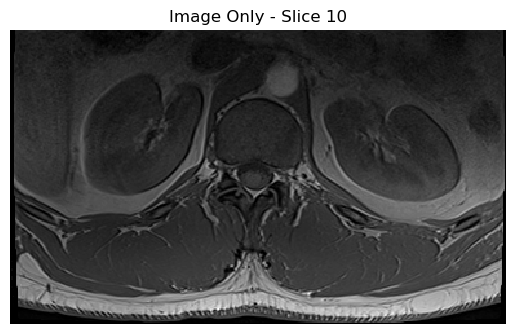

  Visualizing slice 11...


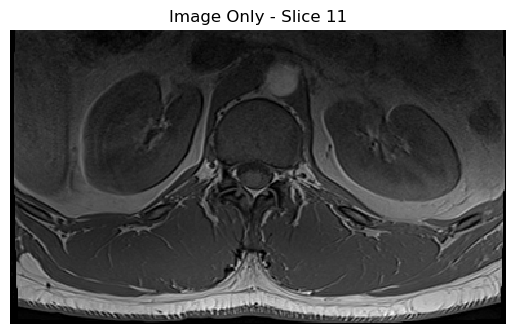


====== Running mode: masks ======
  Visualizing slice 10...


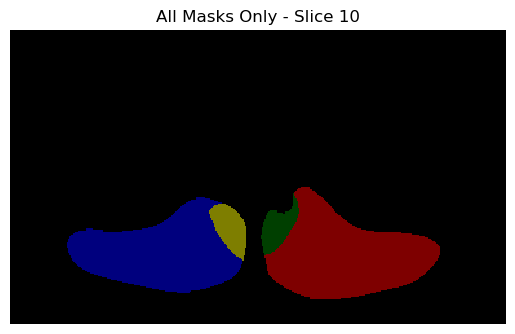

  Visualizing slice 11...


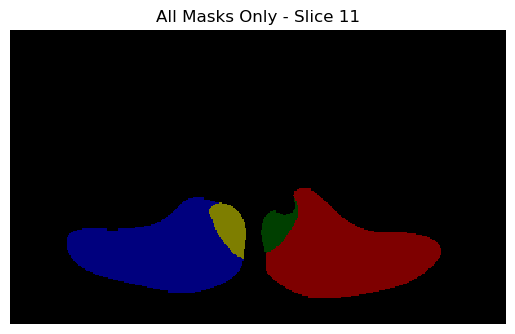


====== Running mode: overlay ======
  Visualizing slice 10...


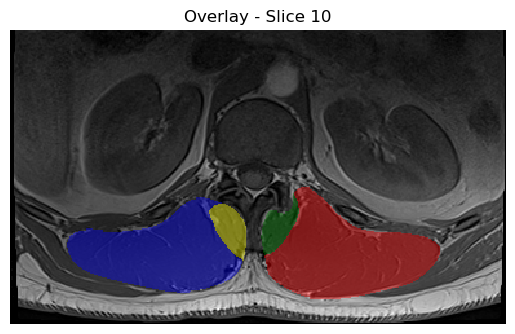

  Visualizing slice 11...


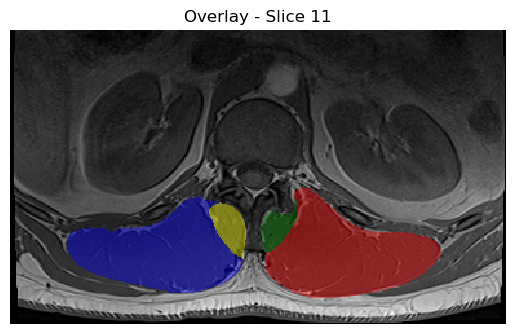

In [8]:
#########################
# Visualization         #
#########################

#########################
# Configuration / Setup #
#########################

# Subject info and specific slice range you wnat to visualize
subject_id = "SBT001"
start_slice = 10
end_slice   = 12  # small range just for demonstration

# If you want to run multiple modes in one go:
modes_to_run = ["image", "masks", "overlay"]  
# e.g. ["image"], or ["mask"], or ["image", "mask", "overlay"], etc.

# If you're using a "mask" mode, define which mask:
mask_name = "L_Mult_II"

PROCESSED_DATA_ROOT = "/Volumes/advent/processed_data"

#########################
# Visualization Code    #
#########################

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

MASK_FILENAMES = {
    "L_Mult_II": "_L_Mult_II.nii",
    "R_Mult_II": "_R_Mult_II.nii",
    "L_ES_II":   "_L_ES_II.nii",
    "R_ES_II":   "_R_ES_II.nii"
}

MASK_COLORS = {
    "L_Mult_II": "green",
    "R_Mult_II": "yellow",
    "L_ES_II":   "red",
    "R_ES_II":   "blue"
}

def load_nifti(filepath):
    nii = nib.load(filepath)
    data = nii.get_fdata()
    return np.asarray(data)

def visualize_image_slice(image_data, slice_idx):
    plt.imshow(image_data[slice_idx], cmap="gray", interpolation="none")
    plt.title(f"Image Only - Slice {slice_idx}")
    plt.axis("off")
    plt.show()

def visualize_single_mask_slice(mask_data, slice_idx, mask_nm):
    if mask_nm in MASK_COLORS:
        cmap = ListedColormap(["black", MASK_COLORS[mask_nm]])
    else:
        cmap = "gray"
    plt.imshow(mask_data[slice_idx], cmap=cmap, interpolation="none")
    plt.title(f"{mask_nm} Only - Slice {slice_idx}")
    plt.axis("off")
    plt.show()

def visualize_all_masks_slice(masks_dict, slice_idx):
    # Start with a black background
    first_mask = next(iter(masks_dict.values()))
    base = np.zeros_like(first_mask[slice_idx])
    plt.imshow(base, cmap="gray", interpolation="none")
    for mname, mdata in masks_dict.items():
        color = MASK_COLORS.get(mname, "magenta")
        cmap = ListedColormap(["none", color])
        plt.imshow(mdata[slice_idx], cmap=cmap, alpha=0.5, interpolation="none")
    plt.title(f"All Masks Only - Slice {slice_idx}")
    plt.axis("off")
    plt.show()

def visualize_overlay_slice(image_data, masks_dict, slice_idx):
    plt.imshow(image_data[slice_idx], cmap="gray", interpolation="none")
    for mname, mdata in masks_dict.items():
        color = MASK_COLORS.get(mname, "magenta")
        cmap = ListedColormap(["none", color])
        plt.imshow(mdata[slice_idx], cmap=cmap, alpha=0.4, interpolation="none")
    plt.title(f"Overlay - Slice {slice_idx}")
    plt.axis("off")
    plt.show()

#########################
# Load the data once    #
#########################
subject_folder = os.path.join(PROCESSED_DATA_ROOT, subject_id)
image_nii_path = os.path.join(subject_folder, f"{subject_id}_images.nii")

if not os.path.isfile(image_nii_path):
    raise FileNotFoundError(f"Image file not found: {image_nii_path}")

image_data = load_nifti(image_nii_path)
depth = image_data.shape[0]

masks_dict = {}
for mname, suffix in MASK_FILENAMES.items():
    mask_path = os.path.join(subject_folder, f"{subject_id}{suffix}")
    if os.path.isfile(mask_path):
        masks_dict[mname] = load_nifti(mask_path)

# Basic slice-range check
if end_slice > depth:
    end_slice = depth
elif start_slice < 0:
    start_slice = 0

#########################
# Now run each mode     #
#########################
for mode in modes_to_run:
    print(f"\n====== Running mode: {mode} ======")
    for slice_idx in range(start_slice, end_slice):
        print(f"  Visualizing slice {slice_idx}...")

        if mode == "image":
            visualize_image_slice(image_data, slice_idx)

        elif mode == "mask":
            if mask_name not in masks_dict:
                print(f"WARNING: {mask_name} not loaded.")
                continue
            visualize_single_mask_slice(masks_dict[mask_name], slice_idx, mask_name)

        elif mode == "masks":
            if not masks_dict:
                print("WARNING: No masks loaded. Skipping.")
                break
            visualize_all_masks_slice(masks_dict, slice_idx)

        elif mode == "overlay":
            if not masks_dict:
                print("WARNING: No masks to overlay. Skipping.")
                break
            visualize_overlay_slice(image_data, masks_dict, slice_idx)


Original order (0,1,2):


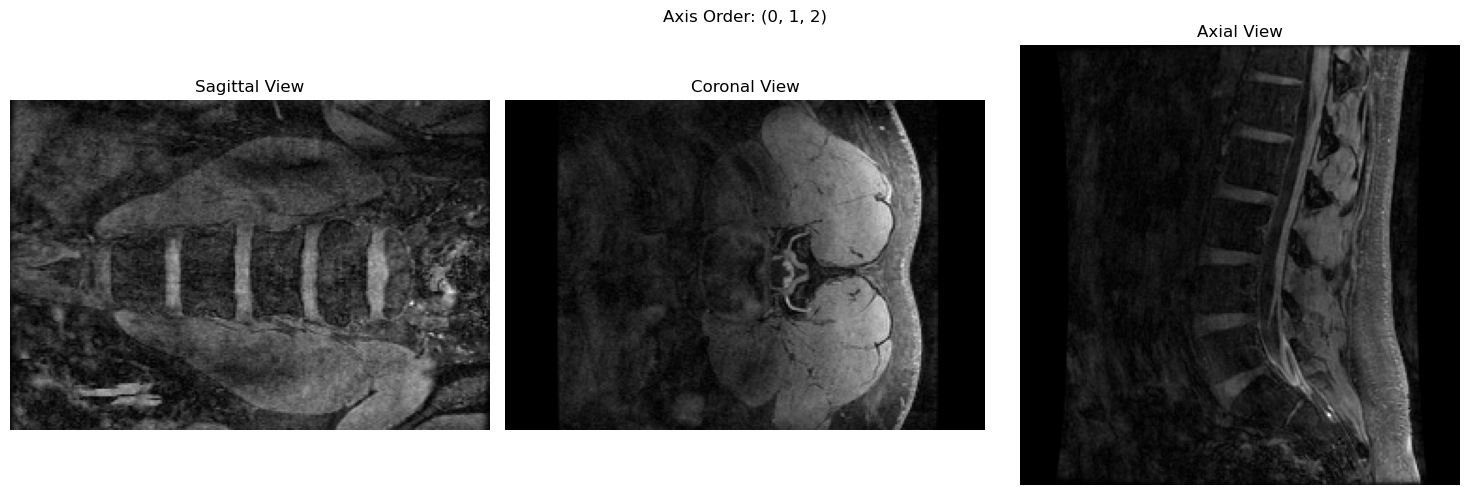


Swapped order (2,0,1):


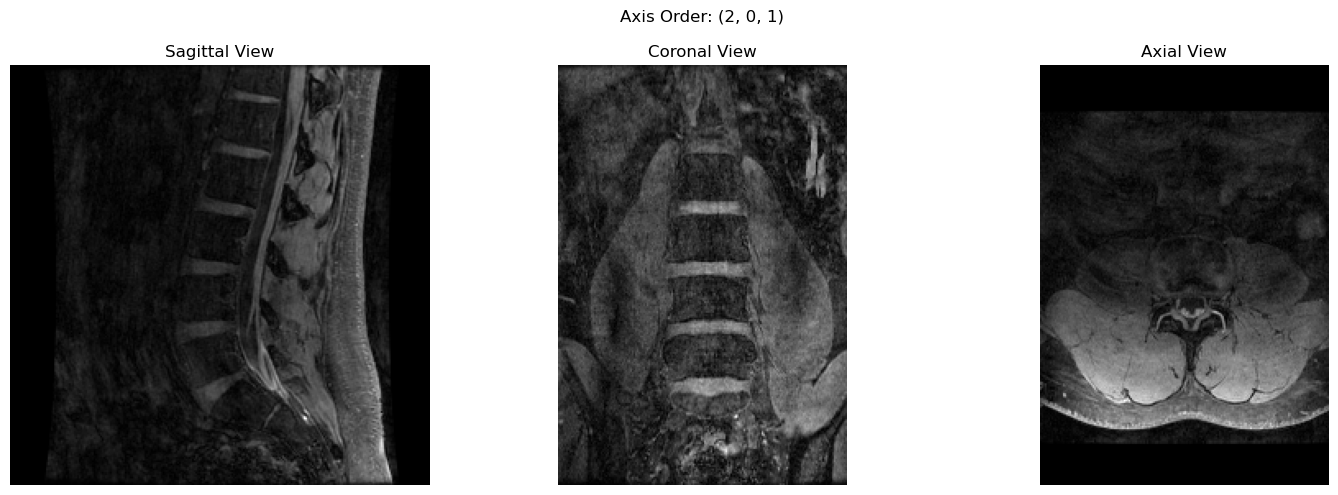


Swapped order (1,0,2):


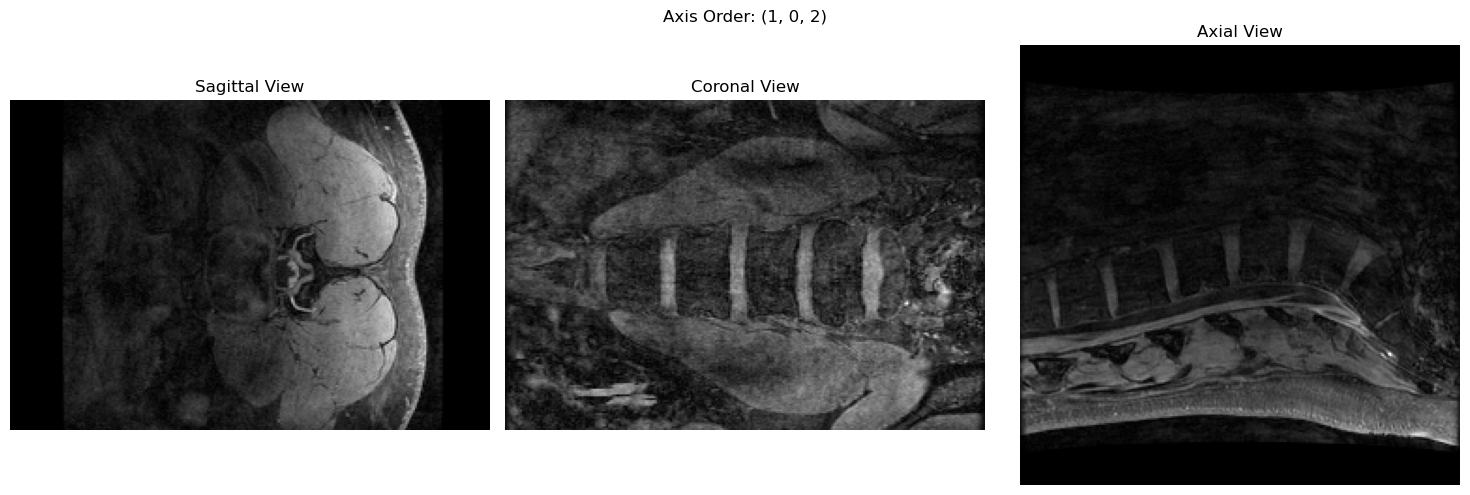

In [10]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def visualize_hdf5_with_swap(h5_path, axis_order=(0,1,2)):
    """
    Visualize HDF5 medical image data with option to swap axes
    axis_order: tuple of 3 integers specifying the new order of axes (e.g., (2,0,1))
    """
    
    with h5py.File(h5_path, 'r') as f:
        # Load the image data
        data = f['image_data'][:]
        
        # Transpose the data according to specified axis order
        data = np.transpose(data, axis_order)
        
        # Create figure with three subplots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Get middle slice indices
        x_mid = data.shape[0] // 2
        y_mid = data.shape[1] // 2
        z_mid = data.shape[2] // 2
        
        # Display views
        sagittal = data[x_mid, :, :]
        coronal = data[:, y_mid, :]
        axial = data[:, :, z_mid]
        
        # Display with consistent orientation
        axes[0].imshow(np.flipud(np.rot90(sagittal)), cmap='gray')
        axes[0].set_title('Sagittal View')
        axes[0].axis('off')
        
        axes[1].imshow(np.flipud(np.rot90(coronal)), cmap='gray')
        axes[1].set_title('Coronal View')
        axes[1].axis('off')
        
        axes[2].imshow(np.flipud(np.rot90(axial)), cmap='gray')
        axes[2].set_title('Axial View')
        axes[2].axis('off')
        
        plt.suptitle(f'Axis Order: {axis_order}')
        plt.tight_layout()
        plt.show()

def save_reordered_hdf5(input_h5_path, output_h5_path, axis_order=(0,1,2)):
    """Save a new HDF5 file with reordered axes"""
    with h5py.File(input_h5_path, 'r') as f_in:
        data = f_in['image_data'][:]
        # Transpose the data
        data_reordered = np.transpose(data, axis_order)
        
        with h5py.File(output_h5_path, 'w') as f_out:
            # Store the reordered data
            f_out.create_dataset('image_data', data=data_reordered, 
                               compression="gzip", compression_opts=9)
            
            # Copy metadata if it exists
            if 'metadata' in f_in:
                meta_grp = f_out.create_group('metadata')
                for key, value in f_in['metadata'].attrs.items():
                    meta_grp.attrs[key] = value
                meta_grp.attrs['axis_reordering'] = str(axis_order)

# Path to your HDF5 file
h5_path = '/Volumes/advent/test/LS012/LS012_IDEALWater.h5'

# Try different axis orders and visualize
print("Original order (0,1,2):")
visualize_hdf5_with_swap(h5_path, (0,1,2))

print("\nSwapped order (2,0,1):")
visualize_hdf5_with_swap(h5_path, (2,0,1))

print("\nSwapped order (1,0,2):")
visualize_hdf5_with_swap(h5_path, (1,0,2))

# Once you find the correct orientation, save it to a new file
# For example, if (2,0,1) looks correct:
correct_order = (2,0,1)  # modify this based on which view looks correct
output_h5_path = '/Volumes/advent/test/LS012/LS012_IDEALWater_reordered.h5'
save_reordered_hdf5(h5_path, output_h5_path, correct_order)

Original order (0,1,2):


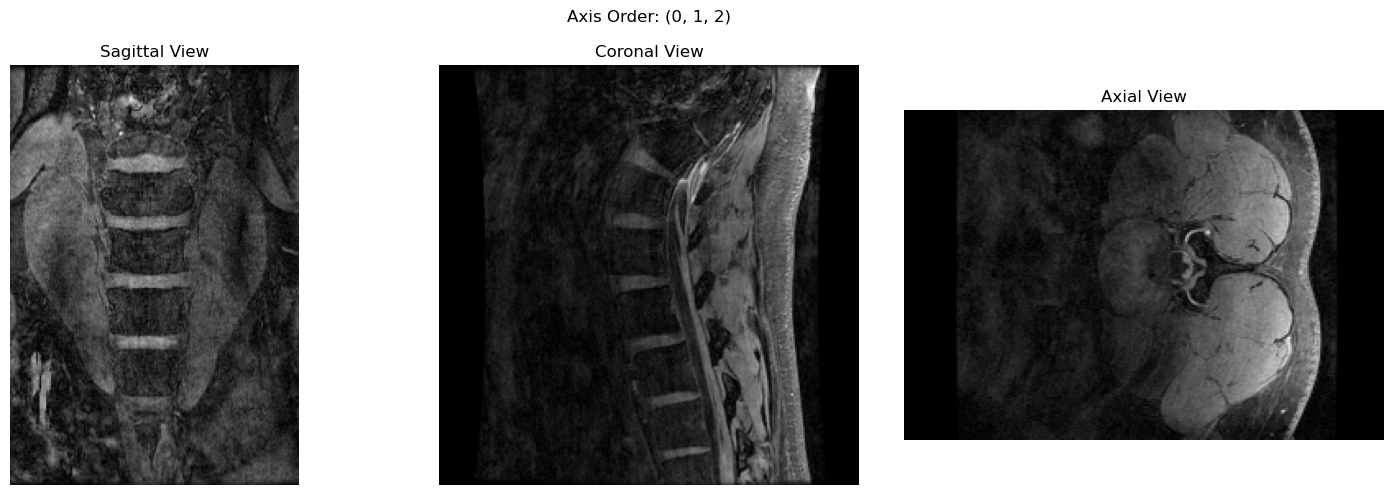


Swapped order (2,0,1):


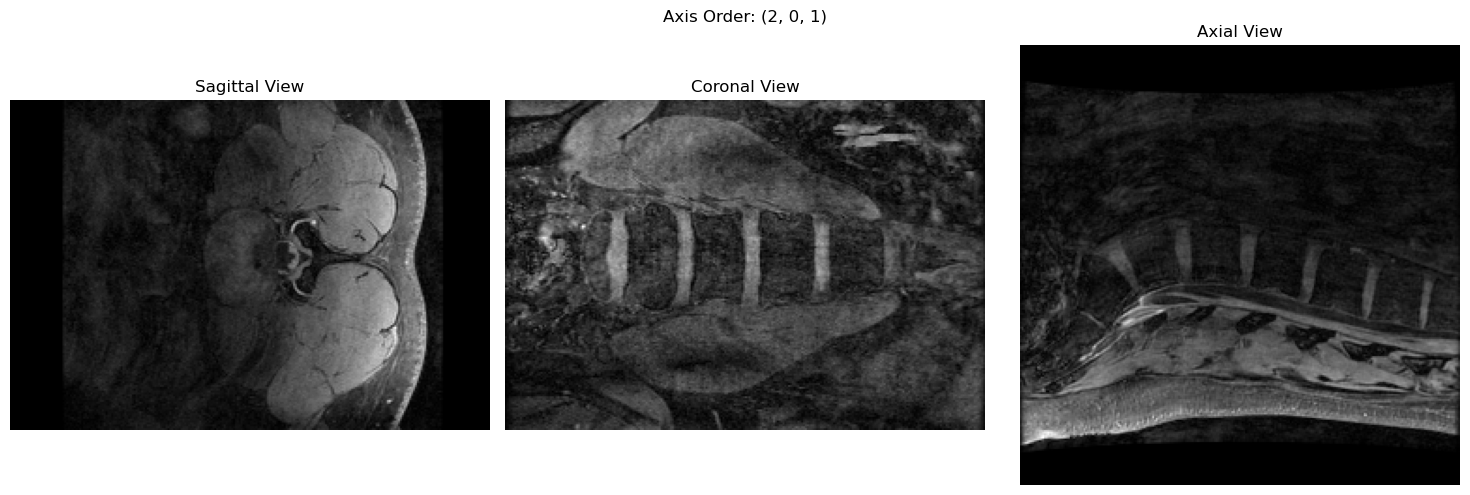


Swapped order (1,0,2):


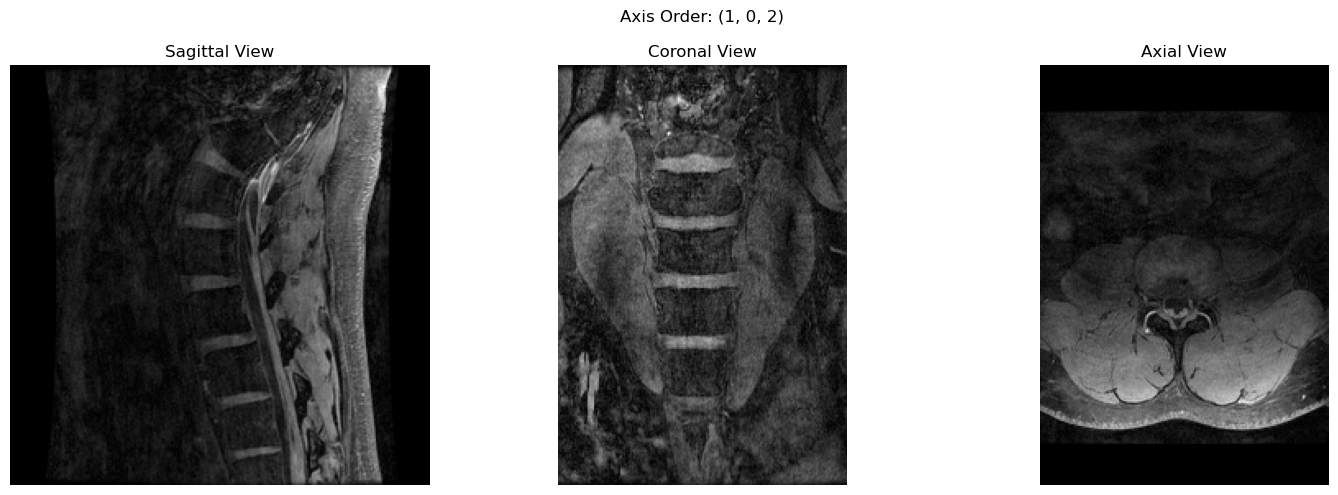

In [11]:
# Path to your HDF5 file
h5_path = '/Volumes/advent/test/SBT003/SBT003_images.h5'

# Try different axis orders and visualize
print("Original order (0,1,2):")
visualize_hdf5_with_swap(h5_path, (0,1,2))

print("\nSwapped order (2,0,1):")
visualize_hdf5_with_swap(h5_path, (2,0,1))

print("\nSwapped order (1,0,2):")
visualize_hdf5_with_swap(h5_path, (1,0,2))

# Once you find the correct orientation, save it to a new file
# For example, if (2,0,1) looks correct:
correct_order = (2,0,1)  # modify this based on which view looks correct
output_h5_path = '/Volumes/advent/test/SBT003/SBT003_images_reordered.h5'
save_reordered_hdf5(h5_path, output_h5_path, correct_order)